
Failed attemps :
- Noise handling with Laplacian smoothing
- Trade layers (model could became better at predicting adversarial image, but became worse at normal one)

In [254]:
import tensorflow as tf
import pickle
import re
import os
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Input
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam,Adagrad
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import cv2

from tensorflow.keras.applications import VGG16,ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input,decode_predictions

from AdversarialImage.Generator import AdversarialGenerator
from AdversarialImage.Noise import *

In [7]:
gen = AdversarialGenerator()

In [8]:
vgg16 = VGG16(weights='imagenet')
# resnet50 = ResNet50(weights="imagenet",include_top=True)
# model.summary()

553467096/553467096 [==============================] - 3s 0us/step


In [9]:
path = "/kaggle/input/imagenet/imagenet/val/"

def imagenet_gen(path,batch_size,image_size=(224,224)):
    images = os.listdir(path)
    while True:
        random.shuffle(images)
        batch_images=[]
        for i in range(0,batch_size):
            img = tf.io.read_file(f"{path}{images[i]}")
            img = tf.io.decode_image(img,channels=3)
#             img = tf.cast(img,dtype=tf.float32)
            img = tf.image.resize(img,(224,224))
#             img *= 1/255 
            batch_images.append(img)
        yield tf.convert_to_tensor(batch_images)
        
def pred(img):
    pred = vgg16.predict(img)
    return tf.argmax(pred,axis=-1)

In [97]:
train_gen = imagenet_gen(path,8)

In [258]:
temp = next(train_gen)

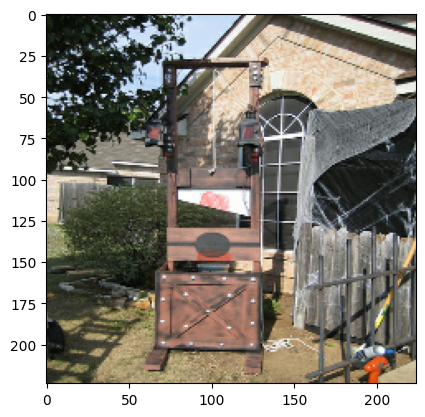

In [259]:
plt.imshow(temp[0]/255.)

In [260]:
temp = temp.numpy()

In [261]:
noise = gen.generate_adversarial_image(temp,method="uniform",low=-0.00005,high=0.00005,out="noise")

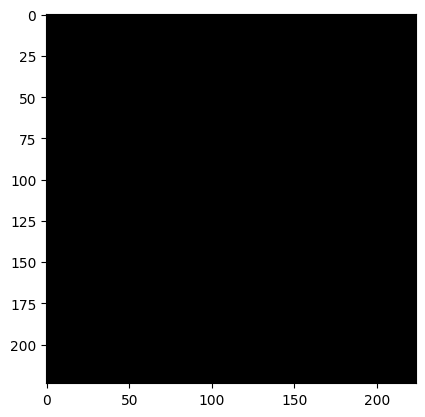

In [262]:
plt.imshow(noise[0]/255.)

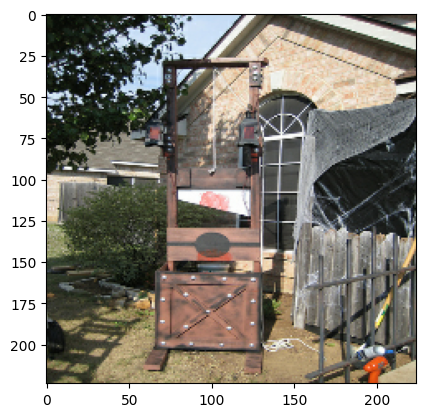

In [263]:
adv = (temp[0]+noise[0])/255.
plt.imshow(adv)

In [269]:
# noise = noise.numpy()
temp_ = cv2.Laplacian(noise[0],ddepth=cv2.CV_32F)

In [275]:
temp_ = np.reshape(temp_,(1,224,224,3))

In [277]:
noise_pred = pred(temp_)
noise_pred

1/1 [==============================] - 0s 257ms/step


<tf.Tensor: shape=(1,), dtype=int64, numpy=array([999])>

In [104]:
temp = vgg_preprocess_input(temp)
noise = vgg_preprocess_input(noise+temp)

In [105]:
noise_pred = pred(noise)
noise_pred

1/1 [==============================] - 0s 21ms/step


<tf.Tensor: shape=(8,), dtype=int64, numpy=array([828, 818, 562, 885, 374, 818, 375, 818])>

In [106]:
nrm_pred = pred(temp)
nrm_pred

1/1 [==============================] - 0s 21ms/step


<tf.Tensor: shape=(8,), dtype=int64, numpy=array([418, 905, 418, 372, 372, 818, 272, 669])>

In [107]:
from sklearn.metrics import accuracy_score
accuracy_score(noise_pred,nrm_pred)

0.125

In [244]:
head = Conv2D(64, (3, 3), activation='relu', padding='same', trainable=False)
head.build(input_shape=(224,224,3))
head.set_weights(vgg16.layers[1].weights)

In [245]:
# this will be the replaceable conv
r = Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")
r.build(input_shape=(224,224,3))

In [246]:
def train(model_normal,model_noise,learning_rate=1e-5):
    optimizer = Adam(learning_rate=learning_rate)
    with tf.GradientTape() as tape:
            tape.watch(r.weights)
            y_true = model_normal(temp)
            y_pred = model_noise(noise)
            loss = tf.keras.losses.mean_squared_error(y_true,y_pred)
            print(tf.reduce_mean(loss))
    gradients = tape.gradient(loss,model_noise.weights)
    optimizer.apply_gradients(zip(gradients,model_noise.weights))


In [247]:
for i in range(10):
    train(head,r,learning_rate=1e-3)

tf.Tensor(601.3353, shape=(), dtype=float32)
tf.Tensor(527.1641, shape=(), dtype=float32)
tf.Tensor(461.38297, shape=(), dtype=float32)
tf.Tensor(403.34103, shape=(), dtype=float32)
tf.Tensor(352.27216, shape=(), dtype=float32)
tf.Tensor(307.50955, shape=(), dtype=float32)
tf.Tensor(268.3126, shape=(), dtype=float32)
tf.Tensor(234.36003, shape=(), dtype=float32)
tf.Tensor(204.97644, shape=(), dtype=float32)
tf.Tensor(179.90405, shape=(), dtype=float32)


In [248]:
def trade_layers(model,new_layer):
    old_layer = model.layers[1].weights.copy()
    model.layers[1].set_weights(new_layer.weights)
    
trade_layers(vgg16,r)

In [249]:
modified_pred = pred(noise)
modified_pred

1/1 [==============================] - 0s 22ms/step


<tf.Tensor: shape=(8,), dtype=int64, numpy=array([701, 545, 701, 701, 549, 405, 701, 534])>

In [250]:
modified_nrm = pred(temp)
modified_nrm

1/1 [==============================] - 0s 21ms/step


<tf.Tensor: shape=(8,), dtype=int64, numpy=array([818, 749, 673,  58, 372, 904, 372, 669])>

In [253]:
accuracy_score(modified_pred,nrm_pred)

0.25

In [252]:
accuracy_score(modified_nrm,nrm_pred)

0.25

In [255]:
vgg16.layers[1].set_weights(head.weights)